In [1]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
Assumptions

1. There is a fixed amount of passengers each day
2. The player does no merging routes
3. 
'''

'\nAssumptions\n\n'

In [113]:
import numpy as np
import random
from datetime import time

# CREATING SAMPLE INFORMATION
route_length = 42 # in kilometers
minimum_fare = 12
additional_charge_per_km = 1.50

# We are assuming that the number of passengers is dominated by commuting workers and students going to and from work and school respectively
# Therefore, the distribution is bimodal centered around 0700 and 1700
n = 16000
mu, sigma = 7, 2
mu2, sigma2 = 17, 2  
normal1 = np.random.normal(mu, sigma, n)
normal2 = np.random.normal(mu2, sigma2, n)


# Removing invalid values (Time is only between 0000 and 2400)
for i in range(len(normal1)):
    if normal1[i] < 0 or normal1[i] > 24:
        normal1[i] = mu

for i in range(len(normal2)):
    if normal2[i] < 0 or normal2[i] > 24:
        normal2[i] = mu

bimodal = np.concatenate([normal1, normal2])

# Turning the random numbers into random time objects and adding them to a DataFrame
info_dict = {'time': [], 'place': [], 'payment': []}
for i in bimodal:
    hour = int(i)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    info_dict['time'].append(time(hour, minute, second))
    location = random.randint(0, route_length)
    info_dict['place'].append(location)
    pay = random.randint(minimum_fare, int(minimum_fare + additional_charge_per_km * (random.randint(0, route_length - location))))
    info_dict['payment'].append(pay)

df = pd.DataFrame(info_dict)
df = df.sort_values('time')
df = df.reset_index()
df = df.drop('index', axis = 1)

In [114]:
# A typical information sheet contains when customers board, where customers board, and how much customers paid
df 

,time,place,payment
0,00:01:17,4,13
1,00:01:18,1,46
2,00:10:18,39,12
3,00:16:32,36,13
4,00:17:22,8,36
...,...,...,...
31995,23:44:23,41,13
31996,23:46:06,29,18
31997,23:53:35,39,13
31998,23:55:49,15,13


In [115]:
# Assuming that the information sheet above is what we will work with

# We do not need the exact time a passenger boards, just the hours
df['hour'] = df['time'].apply(lambda x: x.hour)

# Calculate how much we earn per segment of kilometer per hour
df_gross = df.groupby(['place', 'hour'])['payment'].sum()

df_gross = df_gross.reset_index()


In [116]:
# Final cleaning before graphing
transportation = df.pivot_table(index="hour", columns="place", values="payment", aggfunc = 'sum', fill_value=0)

transportation



place,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
hour,,,,,,,,,,,,,,,,,,,,,
0,0,89,0,0,26,0,0,0,36,0,...,20,0,0,13,0,12,12,12,0,0
1,12,101,155,120,19,36,117,85,131,63,...,30,0,0,39,33,12,12,24,37,24
2,289,246,250,58,216,61,146,62,155,49,...,50,162,155,73,126,91,36,36,61,96
3,489,407,426,599,227,294,361,306,592,365,...,213,243,194,235,163,157,212,169,244,276
4,963,991,909,1069,1128,828,1304,757,581,894,...,528,493,391,450,411,327,376,422,405,468
5,1752,1939,1561,1386,1148,1278,1290,1377,1480,1211,...,898,645,710,579,729,728,742,677,688,576
6,2096,2108,1754,2057,1722,1762,2017,1242,1773,1794,...,1004,940,988,1122,1129,1229,929,635,883,852
7,2185,1715,2515,2234,1929,1644,1780,1879,1966,1756,...,1163,1050,1085,1126,936,961,942,906,892,888
8,1774,1558,1749,1570,1116,1923,1188,1485,1242,1204,...,803,947,881,633,903,616,895,831,696,684


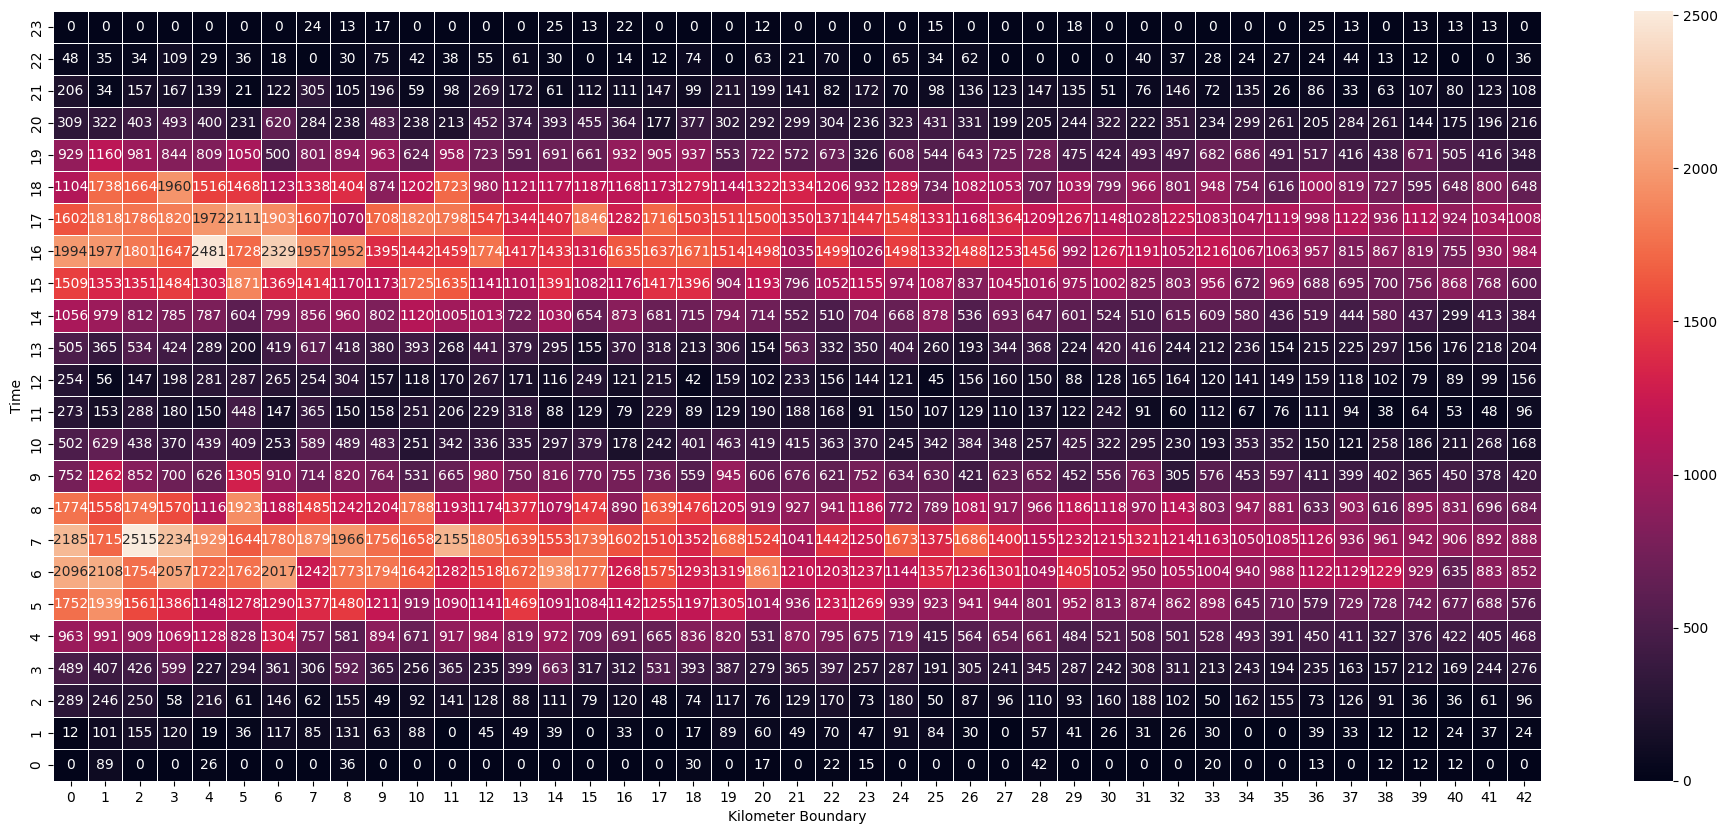

In [120]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(transportation, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.xlabel('Kilometer Boundary')
plt.ylabel('Time')
ax.invert_yaxis()
plt.show()